This is the minimal implementation of this solution of Petfinder Pawpularity, The number of folds, epochs and other models selection are reduced due to longer time training, but the overall strategy is demonstrated.
### Overview
The 3rd-place solution used many different deep learning models to predict Pawpularity scores, including Swin Large, ViT Large, and CaiT. For some models, they treated the problem as a classification task over 101 classes (0–100 Pawpularity) and then converted the predicted probabilities back to a continuous score using a weighted sum. They also added three SVR (Support Vector Regressor) heads to some models, which helps create diversity in the predictions and reduces overfitting by giving slightly different perspectives on the same features. In the second stage, all predictions from the first-stage models and SVR heads were combined using linear regression, which learns the best weights for each model’s output to produce a final, more accurate prediction.
### Strengths
This strategy works well because using the classification trick allows the models to benefit from cross-entropy loss and mixup augmentation, which improves generalization. Multiple SVR heads increase prediction diversity, and linear regression stacking combines all outputs optimally to reduce error. Overall, using many models with diverse predictions and combining them carefully through stacking gives better performance than relying on a single model.
### Differences to our model
Unlike our single image model, they used different models with multiple heads to diversify to diversify evaluaiton. 
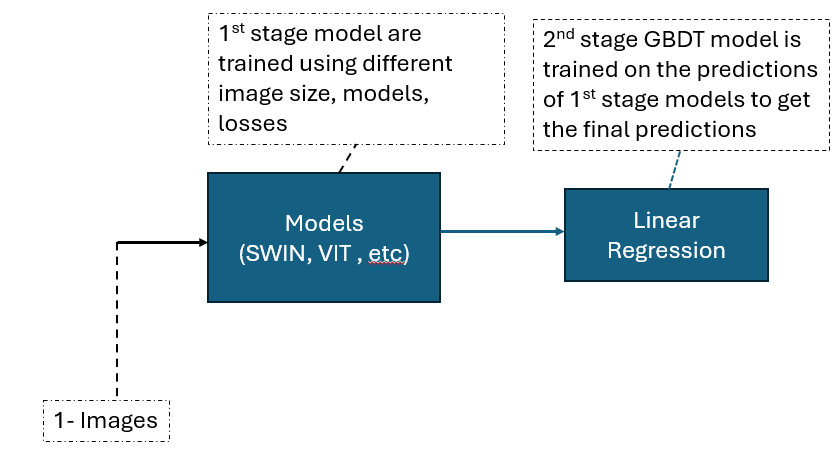

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import timm
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import time
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from cuml.svm import SVR # Using cuml for GPU-accelerated SVR
import albumentations as A
from torch import nn
import joblib

# Set up device and file paths
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BASE_PATH = "inputs/"
OOF_SAVE_DIR = "top3_with_metadata" # 
os.makedirs(OOF_SAVE_DIR, exist_ok=True) 

# --- Metadata Column Names ---
METADATA_COLS = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 
                 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
METADATA_DIM = len(METADATA_COLS) # Should be 12

# --- 1. Data Loading, Metadata Processing, and Stratified Folds ---
train = pd.read_csv(BASE_PATH + 'train.csv') 
train['file'] = train['Id'].apply(lambda x: f'{BASE_PATH}train/{x}.jpg')

# Standardize the Pawpularity target (0-1) and extract metadata features
train['target_normalized'] = train['Pawpularity'] / 100.0
train['metadata'] = train[METADATA_COLS].values.tolist() # Store metadata as a list/array per row

# Stratified folds (5-fold )
train['bin'] = (train['Pawpularity'] // 5).round()
train['fold'] = -1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for i, (_, val_idx) in enumerate(skf.split(train, train['bin'])):
    train.loc[val_idx, 'fold'] = i
train['fold'] = train['fold'].astype(int)



In [19]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file,target_normalized,metadata,bin,fold
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,inputs/train/0007de18844b0dbbb5e1f607da0606e0.jpg,0.63,"[0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]",12,0
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,inputs/train/0009c66b9439883ba2750fb825e1d7db.jpg,0.42,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",8,1
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,inputs/train/0013fd999caf9a3efe1352ca1b0d937e.jpg,0.28,"[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]",5,2
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,inputs/train/0018df346ac9c1d8413cfcc888ca8246.jpg,0.15,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",3,4
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,inputs/train/001dc955e10590d3ca4673f034feeef2.jpg,0.72,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]",14,0


In [ ]:
# --- 2. Dataset and Transforms (Updated for Metadata) ---
class PetDataset(Dataset):
    def __init__(self, image_paths, targets, metadata, transform=None, target_dtype=torch.float): # Added metadata
        self.image_paths = image_paths
        self.targets = targets 
        self.metadata = metadata # New metadata array
        self.transform = transform
        self.target_dtype = target_dtype

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = np.array(image)
        if self.transform:
            image = self.transform(image=image)["image"]
        
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'metadata': torch.tensor(self.metadata[idx], dtype=torch.float), # Return metadata as float tensor
            'target': torch.tensor(self.targets[idx], dtype=self.target_dtype) 
        }

def get_transforms(img_size=224, aug_type='light', is_train=True):
    #  transforms 
    if is_train:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
        ])
    else:
        return A.Compose([A.Resize(img_size, img_size)])



In [ ]:
# --- 3. Model Definition (Updated for Metadata) ---
class PetModel(nn.Module):
    def __init__(self, model_name, num_classes, metadata_dim, pretrained=True): # Added metadata_dim
        super().__init__()
        # 1. Image Backbone (without the final linear head)
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0) 
        # Get the feature dimension from the backbone
        self.feature_dim = self.model.num_features
        
        # 2. Final Head (takes concatenated features)
        total_input_dim = self.feature_dim + metadata_dim
        self.num_classes = num_classes
        self.final_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(total_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes) # Final output layer
        )
        
    def forward(self, x_img, x_meta): # Accepts both image and metadata
       
        img_features = self.model(x_img)
        combined_features = torch.cat([img_features, x_meta], dim=1)
        out = self.final_head(combined_features)
        
     
        if self.num_classes == 1:
            return out.squeeze(-1)  # Always squeeze for BCE
        return out



In [ ]:

# --- 4. Training Function with Dual Loss Logic (Updated with RMSE printing and Early Stopping) ---
def train_dl_model(model_name, train_df, loss_type, n_epochs, batch_size, 
                   img_size, lr, save_dir):
    
    os.makedirs(save_dir, exist_ok=True)
    n_folds = 5
    oof_preds = np.zeros(len(train_df), dtype=float)

    # Define Early Stopping parameters
    max_patience = 3 

    # Determine loss and class count
    if loss_type == 'CE':
        num_classes = 100
        criterion = nn.CrossEntropyLoss()
        target_dtype = torch.long
    elif loss_type == 'BCE':
        num_classes = 1
        criterion = nn.BCEWithLogitsLoss()
        target_dtype = torch.float
    else:
        raise ValueError("loss_type must be 'CE' or 'BCE'")

    for fold in range(n_folds):
        print(f"\n{'='*70}")
        print(f"Model: {model_name} ({loss_type}) | Fold {fold+1}/{n_folds} (With Metadata)")
        print(f"{'='*70}")
        
        # --- Data Split and Target Preparation ---
        tr_ind = train_df['fold'] != fold
        val_ind = train_df['fold'] == fold
        
        tr_paths = train_df.loc[tr_ind, 'file'].values
        val_paths = train_df.loc[val_ind, 'file'].values
        val_targets_original = train_df.loc[val_ind, 'Pawpularity'].values 
        
        tr_metadata = np.stack(train_df.loc[tr_ind, 'metadata'].values)
        val_metadata = np.stack(train_df.loc[val_ind, 'metadata'].values)
        
        # Targets specific to Loss Type
        if loss_type == 'BCE':
            tr_targets = train_df.loc[tr_ind, 'target_normalized'].values
            val_targets_normalized = train_df.loc[val_ind, 'target_normalized'].values
        elif loss_type == 'CE':
            tr_targets = (train_df.loc[tr_ind, 'Pawpularity'].values - 1).astype(int)
            val_targets_normalized = (train_df.loc[val_ind, 'Pawpularity'].values - 1).astype(int)
        
        # Create datasets (passing metadata)
        train_dataset = PetDataset(tr_paths, tr_targets, tr_metadata,
                                   transform=get_transforms(img_size, 'light', is_train=True),
                                   target_dtype=target_dtype)
        val_dataset = PetDataset(val_paths, val_targets_normalized, val_metadata,
                                 transform=get_transforms(img_size, 'light', is_train=False),
                                 target_dtype=target_dtype)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False, num_workers=4, pin_memory=True)

        # Model, optimizer, scheduler (passing metadata_dim)
        #  METADATA_DIM needs to be defined in the global scope!
        model = PetModel(model_name, num_classes=num_classes, metadata_dim=METADATA_DIM, pretrained=True).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=1)

        best_val_rmse = float('inf')
        best_val_preds = None
        patience = 0 # Initialize patience

        for epoch in range(n_epochs):
            # Training Loop
            model.train()
            train_loss = 0.0
            train_count = 0
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
                imgs = batch['image'].to(device)
                metas = batch['metadata'].to(device) 
                tgts = batch['target'].to(device) 
                
                optimizer.zero_grad()
                logits = model(imgs, metas)
                loss = criterion(logits, tgts) 
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item() * len(imgs)
                train_count += len(imgs)
            
            avg_train_loss = train_loss / train_count
            scheduler.step()

            # Validation Loop
            model.eval()
            val_preds = []
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Valid]"):
                    imgs = batch['image'].to(device)
                    metas = batch['metadata'].to(device) 
                    logits = model(imgs, metas) 
                    
                    if loss_type == 'BCE':
                        scaled = torch.sigmoid(logits) * 100.0
                    elif loss_type == 'CE':
                        predicted_classes = torch.argmax(logits, dim=1) 
                        scaled = (predicted_classes.float() + 1.0)
                        
                    val_preds.extend(scaled.cpu().numpy())

            val_preds = np.clip(np.array(val_preds), 1, 100)
            val_rmse = np.sqrt(np.mean((val_targets_original - val_preds) ** 2))
            
            # --- Per-Epoch RMSE and Early Stopping Logic ---
            
            # Print current epoch results
            print(f"   Epoch {epoch+1}/{n_epochs} | Train Loss: {avg_train_loss:.4f} | Val RMSE: {val_rmse:.4f}", end='')

            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_val_preds = val_preds.copy()
                
                # Save best model weights 
                torch.save(model.state_dict(), os.path.join(save_dir, f"{model_name}_{loss_type}_fold{fold}.pth"))
                patience = 0  # Reset patience on improvement
                print(" -> **BEST** model saved!")
            else:
                patience += 1 # Increment patience when no improvement
                print(f" | Patience: {patience}/{max_patience}")

                if patience >= max_patience:
                    print(f"\n   Early stopping triggered (patience={max_patience})")
                    break # Stop training for this fold

        # Store best predictions for this fold
        oof_preds[val_ind.values] = best_val_preds
        print(f"\nFold {fold+1} Complete | Final Best Val RMSE: {best_val_rmse:.4f}")
        
        del model, optimizer, scheduler, train_dataset, val_dataset, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()

    # Calculate overall OOF RMSE and save
    overall_rmse = np.sqrt(np.mean((train_df['Pawpularity'].values - oof_preds) ** 2))
    print(f"\n{'='*70}")
    print(f"{model_name} ({loss_type}) - Overall OOF RMSE: {overall_rmse:.4f}")
    print(f"{'='*70}")
    np.save(os.path.join(save_dir, f"oof_{model_name}_{loss_type}.npy"), oof_preds)
    return oof_preds, overall_rmse

In [ ]:
# --- 5. Configuration and Execution ---

print("PART 1: TRAINING DL MODELS & GENERATING OOFs WITH METADATA")

# Define the two models
dl_models_config = [
    
    # Model 1: Simple Regression (BCE Loss)
    {"name": "swin_base_patch4_window7_224", "size": 224, "loss_type": "BCE", "lr": 1e-4, "epochs": 3, "batch_size": 16},
     # Model 2: Multi-Class Classification (CE Loss)
    {"name": "vit_base_patch16_384", "size": 384, "loss_type": "CE", "lr": 5e-5, "epochs": 3, "batch_size": 16},
   
  
]

cnn_oofs = {}

for cfg in dl_models_config:
    oof, rmse = train_dl_model(
        model_name=cfg["name"],
        train_df=train,
        loss_type=cfg["loss_type"],
        n_epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        img_size=cfg["size"],
        lr=cfg["lr"],
        save_dir=OOF_SAVE_DIR
    )
    cnn_oofs[f"{cfg['name']}_{cfg['loss_type']}"] = oof

# --- 6. 2nd Stage Ensemble: SVR Heads and Linear Regression  ---

print("PART 2: 2ND STAGE ENSEMBLE (SVR + LINEAR REGRESSION)")

# Retrieve OOF predictions
OOF_BCE = cnn_oofs[f"{dl_models_config[0]['name']}_{dl_models_config[0]['loss_type']}"]
OOF_CE = cnn_oofs[f"{dl_models_config[1]['name']}_{dl_models_config[1]['loss_type']}"]
targets = train['Pawpularity'].values

# --- 6A. Train Two SVR Heads (on BCE Model OOFs) ---
# ... (SVR training logic here)
OOF_BCE_reshaped = OOF_BCE.reshape(-1, 1)

svr1 = SVR(kernel='rbf', C=1.0, epsilon=0.1) 
svr1.fit(OOF_BCE_reshaped, targets)
OOF_SVR1 = svr1.predict(OOF_BCE_reshaped)

svr2 = SVR(kernel='linear', C=0.5, epsilon=0.05) 
svr2.fit(OOF_BCE_reshaped, targets)
OOF_SVR2 = svr2.predict(OOF_BCE_reshaped)

print(f"SVR1 OOF RMSE: {np.sqrt(np.mean((targets - OOF_SVR1) ** 2)):.4f}")
print(f"SVR2 OOF RMSE: {np.sqrt(np.mean((targets - OOF_SVR2) ** 2)):.4f}")

# --- 6B. Train Final Linear Regression Ensemble ---
meta_features = np.stack([OOF_BCE, OOF_CE, OOF_SVR1, OOF_SVR2], axis=1)

meta_model = LinearRegression()
meta_model.fit(meta_features, targets)

final_oof_preds = np.clip(meta_model.predict(meta_features), 1, 100) 
final_rmse = np.sqrt(np.mean((targets - final_oof_preds) ** 2))

print(f"\n{'#'*70}")
print(f"Final 2nd Stage Ensemble OOF RMSE : {final_rmse:.4f}")
print(f"{'#'*70}")
    
# final ensemble OOF predictions and meta-models
np.save(os.path.join(OOF_SAVE_DIR, "oof_final_ensemble.npy"), final_oof_preds)
joblib.dump(meta_model, os.path.join(OOF_SAVE_DIR, "meta_model.pkl"))
joblib.dump(svr1, os.path.join(OOF_SAVE_DIR, "svr1_model.pkl"))
joblib.dump(svr2, os.path.join(OOF_SAVE_DIR, "svr2_model.pkl"))

PART 1: TRAINING DL MODELS & GENERATING OOFs WITH METADATA

Model: swin_base_patch4_window7_224 (BCE) | Fold 1/5 (With Metadata)


Epoch 1/3 [Valid]: 100%|██████████| 62/62 [00:14<00:00,  4.35it/s]


   Epoch 1/3 | Train Loss: 0.6670 | Val RMSE: 20.6660 -> **BEST** model saved!


Epoch 2/3 [Valid]: 100%|██████████| 62/62 [00:15<00:00,  4.07it/s]


   Epoch 2/3 | Train Loss: 0.6652 | Val RMSE: 20.6164 -> **BEST** model saved!


Epoch 3/3 [Valid]: 100%|██████████| 62/62 [00:15<00:00,  4.06it/s]


   Epoch 3/3 | Train Loss: 0.6624 | Val RMSE: 18.9285 -> **BEST** model saved!

Fold 1 Complete | Final Best Val RMSE: 18.9285

Model: swin_base_patch4_window7_224 (BCE) | Fold 2/5 (With Metadata)


Epoch 1/3 [Valid]: 100%|██████████| 62/62 [00:14<00:00,  4.35it/s]


   Epoch 1/3 | Train Loss: 0.6642 | Val RMSE: 20.6492 -> **BEST** model saved!


Epoch 2/3 [Valid]: 100%|██████████| 62/62 [00:15<00:00,  4.06it/s]


   Epoch 2/3 | Train Loss: 0.6575 | Val RMSE: 19.5457 -> **BEST** model saved!


Epoch 3/3 [Valid]: 100%|██████████| 62/62 [00:15<00:00,  4.08it/s]


   Epoch 3/3 | Train Loss: 0.6406 | Val RMSE: 18.4695 -> **BEST** model saved!

Fold 2 Complete | Final Best Val RMSE: 18.4695

Model: swin_base_patch4_window7_224 (BCE) | Fold 3/5 (With Metadata)


Epoch 1/3 [Valid]: 100%|██████████| 62/62 [00:14<00:00,  4.29it/s]


   Epoch 1/3 | Train Loss: 0.6669 | Val RMSE: 20.0028 -> **BEST** model saved!


Epoch 2/3 [Valid]: 100%|██████████| 62/62 [00:14<00:00,  4.29it/s]


   Epoch 2/3 | Train Loss: 0.6593 | Val RMSE: 19.8288 -> **BEST** model saved!


Epoch 3/3 [Valid]: 100%|██████████| 62/62 [00:15<00:00,  4.08it/s]


   Epoch 3/3 | Train Loss: 0.6461 | Val RMSE: 18.6921 -> **BEST** model saved!

Fold 3 Complete | Final Best Val RMSE: 18.6921

Model: swin_base_patch4_window7_224 (BCE) | Fold 4/5 (With Metadata)


Epoch 1/3 [Valid]: 100%|██████████| 62/62 [00:14<00:00,  4.30it/s]


   Epoch 1/3 | Train Loss: 0.6672 | Val RMSE: 20.8869 -> **BEST** model saved!


Epoch 2/3 [Valid]: 100%|██████████| 62/62 [00:14<00:00,  4.16it/s]


   Epoch 2/3 | Train Loss: 0.6660 | Val RMSE: 20.6553 -> **BEST** model saved!


Epoch 3/3 [Valid]: 100%|██████████| 62/62 [00:15<00:00,  4.08it/s]


   Epoch 3/3 | Train Loss: 0.6643 | Val RMSE: 19.6217 -> **BEST** model saved!

Fold 4 Complete | Final Best Val RMSE: 19.6217

Model: swin_base_patch4_window7_224 (BCE) | Fold 5/5 (With Metadata)


Epoch 1/3 [Valid]: 100%|██████████| 62/62 [00:15<00:00,  4.08it/s]


   Epoch 1/3 | Train Loss: 0.6674 | Val RMSE: 20.6180 -> **BEST** model saved!


Epoch 2/3 [Valid]: 100%|██████████| 62/62 [00:14<00:00,  4.26it/s]


   Epoch 2/3 | Train Loss: 0.6661 | Val RMSE: 20.6204 | Patience: 1/3


Epoch 3/3 [Valid]: 100%|██████████| 62/62 [00:14<00:00,  4.27it/s]


   Epoch 3/3 | Train Loss: 0.6652 | Val RMSE: 20.6768 | Patience: 2/3

Fold 5 Complete | Final Best Val RMSE: 20.6180

swin_base_patch4_window7_224 (BCE) - Overall OOF RMSE: 19.2816

Model: vit_base_patch16_384 (CE) | Fold 1/5 (With Metadata)


Epoch 1/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]


   Epoch 1/3 | Train Loss: 4.3887 | Val RMSE: 31.8708 -> **BEST** model saved!


Epoch 2/3 [Valid]: 100%|██████████| 62/62 [00:41<00:00,  1.48it/s]


   Epoch 2/3 | Train Loss: 4.2860 | Val RMSE: 21.7510 -> **BEST** model saved!


Epoch 3/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]


   Epoch 3/3 | Train Loss: 4.2658 | Val RMSE: 23.3490 | Patience: 1/3

Fold 1 Complete | Final Best Val RMSE: 21.7510

Model: vit_base_patch16_384 (CE) | Fold 2/5 (With Metadata)


Epoch 1/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]


   Epoch 1/3 | Train Loss: 4.3786 | Val RMSE: 22.1323 -> **BEST** model saved!


Epoch 2/3 [Valid]: 100%|██████████| 62/62 [00:41<00:00,  1.48it/s]


   Epoch 2/3 | Train Loss: 4.2920 | Val RMSE: 23.3117 | Patience: 1/3


Epoch 3/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]


   Epoch 3/3 | Train Loss: 4.2648 | Val RMSE: 22.4715 | Patience: 2/3

Fold 2 Complete | Final Best Val RMSE: 22.1323

Model: vit_base_patch16_384 (CE) | Fold 3/5 (With Metadata)


Epoch 1/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]


   Epoch 1/3 | Train Loss: 4.3996 | Val RMSE: 22.1579 -> **BEST** model saved!


Epoch 2/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]


   Epoch 2/3 | Train Loss: 4.2977 | Val RMSE: 21.4306 -> **BEST** model saved!


Epoch 3/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]


   Epoch 3/3 | Train Loss: 4.2638 | Val RMSE: 22.0135 | Patience: 1/3

Fold 3 Complete | Final Best Val RMSE: 21.4306

Model: vit_base_patch16_384 (CE) | Fold 4/5 (With Metadata)


Epoch 1/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]


   Epoch 1/3 | Train Loss: 4.3789 | Val RMSE: 64.9547 -> **BEST** model saved!


Epoch 2/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]


   Epoch 2/3 | Train Loss: 4.2826 | Val RMSE: 22.9059 -> **BEST** model saved!


Epoch 3/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]


   Epoch 3/3 | Train Loss: 4.2638 | Val RMSE: 24.3373 | Patience: 1/3

Fold 4 Complete | Final Best Val RMSE: 22.9059

Model: vit_base_patch16_384 (CE) | Fold 5/5 (With Metadata)


Epoch 1/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]


   Epoch 1/3 | Train Loss: 4.3747 | Val RMSE: 23.3867 -> **BEST** model saved!


Epoch 2/3 [Valid]: 100%|██████████| 62/62 [00:41<00:00,  1.48it/s]


   Epoch 2/3 | Train Loss: 4.2860 | Val RMSE: 22.3565 -> **BEST** model saved!


Epoch 3/3 [Valid]: 100%|██████████| 62/62 [00:42<00:00,  1.47it/s]


   Epoch 3/3 | Train Loss: 4.2590 | Val RMSE: 22.1567 -> **BEST** model saved!

Fold 5 Complete | Final Best Val RMSE: 22.1567

vit_base_patch16_384 (CE) - Overall OOF RMSE: 22.0808

PART 2: 2ND STAGE ENSEMBLE (SVR + LINEAR REGRESSION)
[W] [22:40:31.292858] SVR with the linear kernel can be much faster using the specialized solver provided by LinearSVR. Consider switching to LinearSVR if tranining takes too long.
SVR1 OOF RMSE: 19.6120
SVR2 OOF RMSE: 19.5875

######################################################################
Final 2nd Stage Ensemble OOF RMSE : 19.2612
######################################################################


['top3_with_metadata/svr2_model.pkl']

In [18]:
# --- 6B. Final Linear Regression on two SVR Heads and one NN Head ---
meta_features1 = np.stack([OOF_CE, OOF_SVR1, OOF_SVR2], axis=1)

meta_model1 = LinearRegression()
meta_model1.fit(meta_features1, targets)

final_oof_preds1 = np.clip(meta_model1.predict(meta_features1), 1, 100) 
final_rmse1 = np.sqrt(np.mean((targets - final_oof_preds1) ** 2))

print(f"\n{'#'*70}")
print(f"Final Linear Regression on two SVR Heads and one NN Head ensemble : {final_rmse1:.4f}")
print(f"{'#'*70}")


######################################################################
Final Linear Regression on two SVR Heads and one NN Head ensemble : 19.2612
######################################################################
